# The Wavefunction Visualizer

This notebook contains functions to visualize quantum wavefunctions. You can view any wavefunction in 2D, or 3D, either animated or with a slider for time. Simply define a Python function that gives $\Psi(x,t)$ and call one of the util functions given.

## Utils

In [2]:
# Imports.
import numpy as np
import siunits as u
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from matplotlib.animation import FuncAnimation
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import rc
from IPython.display import HTML, Image, display
from collections.abc import Iterable
%matplotlib notebook

In [3]:
"""
Constants.

You may use them, but the more important part is visualizing the wavefunction's overall shape, so using dummy
values for any constants should be sufficient.
"""
pi = np.pi # To make code more succinct.

c = 299_792_458 # Speed of light.
h = 6.62607015e-34 # Planck's constant.
hbar = h / (2 * pi)
eps0 = 8.8541878128e-12 # Permitivity of free space.
e = 1.602176634e-19 # Elementary charge.
m_e = 9.1093837015e-31 # Mass of electron.
a0 = 5.29177210903e-11 # Bohr radius.

In [4]:
""" Helpers. """

def graph_wavefunction(psi_func, x_range, t, y_range, name=None, x_count=1000):
    """ Graphs only one moment in time. """
    x = np.linspace(x_range[0], x_range[1], x_count)
    psi = psi_func(x, t)
    psi_sq = np.abs(psi)**2
    psi_arg = np.angle(psi)
    psi_re = np.real(psi)
    psi_im = np.imag(psi)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.plot(x, psi_sq)
    ax.plot(x, psi_arg)
    ax.plot(x, psi_re)
    ax.plot(x, psi_im)

    title = name + ' ' if name else ''
    ax.set_title(title + 'wavefunction $\Psi(x,t)$')
    ax.set_xlabel('x')
    ax.set_ylabel('value')
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    ax.legend(['$|\Psi|^2$', 'arg$(\Psi)$', '$\Re(\Psi)$', '$\Im(\Psi)$'])

    plt.show()

def graph_wavefunction_animated(psi_func, x_range, t_range, y_range, name=None, x_count=500, t_count=40,
                               use_html=False, save_as_gif=False, export_name=None, gif_fps=60, legend=None):
    """
    Returns the animation object. To ensure smooth execution, save this object outside the function.
    
    If psi_func is a list, graphs each function. Otherwise graphs the norm squared, argument, real part,
    and imaginary part of the one function provided.
    """
    multiple = isinstance(psi_func, Iterable)
    fig, ax = plt.subplots()
    
    x = np.linspace(x_range[0], x_range[1], x_count)
    if multiple:
        lines = []
        for func in psi_func:
            [line] = ax.plot(x, func(x, t_range[0]))
            lines.append(line)
    else:
        psi = psi_func(x, t_range[0])
        [line_psi_sq] = ax.plot(x, np.abs(psi)**2)
        [line_psi_arg] = ax.plot(x, np.angle(psi))
        [line_psi_re] = ax.plot(x, np.real(psi))
        [line_psi_im] = ax.plot(x, np.imag(psi))

    legend = legend if legend else ['$|\Psi|^2$', 'arg$(\Psi)$', '$\Re(\Psi)$', '$\Im(\Psi)$']
    def init():
        title = name + ' ' if name else ''
        ax.set_title(title + 'wavefunction $\Psi(x,t)$')
        ax.set_xlabel('x')
        ax.set_ylabel('value')
        ax.set_xlim(x_range)
        ax.set_ylim(y_range)
        ax.legend(legend)
        if multiple:
            return lines
        else:
            return [line_psi_sq, line_psi_re, line_psi_arg, line_psi_im]

    def update(t):
        if multiple:
            for i in range(len(psi_func)):
                lines[i].set_ydata(psi_func[i](x, t))
            return lines
        else:
            psi = psi_func(x, t)
            line_psi_sq.set_ydata(np.abs(psi)**2)
            line_psi_arg.set_ydata(np.angle(psi))
            line_psi_re.set_ydata(np.real(psi))
            line_psi_im.set_ydata(np.imag(psi))
            return [line_psi_sq, line_psi_re, line_psi_arg, line_psi_im]

    rc('animation', html='html5')
    ani = FuncAnimation(fig, update, frames=np.linspace(t_range[0], t_range[1], t_count),
                        init_func=init, blit=True)
    if use_html:
        HTML(ani.to_jshtml())
    else:
        plt.show()
    
    if save_as_gif:
        export_name = export_name if export_name else name
        if export_name:
            print(f'Saving as {export_name}.gif...')
            ani.save(f'./{export_name}.gif', writer='imagemagick', fps=gif_fps)
            print('Done')
        else:
            print('Cannot save as gif without a file name, aborting')
    return ani

def graph_wavefunction_3d(psi_func, x_range, t, y_ranges, name=None, x_count=500, trace_xs=[]):
    """
    x_traces is a list of x values where an animated line will be drawn from 0 to Psi(x, t).
    """
    fig = plt.figure()
    ax = p3.Axes3D(fig)

    psi_re = lambda x: np.real(psi_func(x, t))
    psi_im = lambda x: np.imag(psi_func(x, t))
    psi_sq = lambda x: np.abs(psi_func(x, t))**2

    x = np.linspace(x_range[0], x_range[1], x_count)
    zeros = np.full(x_count, 0)
    # Use y as imaginary Psi, z as real Psi.
    ax.plot(x, psi_im(x), psi_re(x))
    ax.plot(x, zeros, psi_sq(x))
    ax.plot(x, zeros, zeros)

    for x_tr in trace_xs:
        trace_array = np.full(x_count, x_tr)
        psi_tr_re = psi_re(x_tr)
        psi_tr_im = psi_im(x_tr)
        ax.plot(trace_array, np.linspace(0, psi_tr_im, x_count), np.linspace(0, psi_tr_re, x_count))

    title = name + ' ' if name else ''
    ax.set_title(title + 'wavefunction $\Psi(x,t)$')

    # Setting the axes properties
    ax.set_xlim3d(x_range)
    ax.set_xlabel('x')

    ax.set_ylim3d(y_ranges[0])
    ax.set_ylabel(r'$\Im(\Psi(x,t))$')

    ax.set_zlim3d(y_ranges[1])
    ax.set_zlabel(r'$\Re(\Psi(x,t))$')

    ax.set_title(name)
    ax.legend(['$\Psi$', '$|\Psi|^2$', 'x axis'])

    plt.show()

def graph_wavefunction_3d_animated(psi_func, x_range, t_range, y_ranges, name=None, x_count=500, t_count=40,
                                   trace_xs=[], use_html=False, save_as_gif=False, export_name=None, gif_fps=60):
    """
    Returns the animation object. To ensure smooth execution, save this object outside the function.
    
    x_traces is a list of x values where an animated line will be drawn from 0 to Psi(x, t).
    """
    fig = plt.figure()
    ax = p3.Axes3D(fig)

    psi_re = lambda x, t: np.real(psi_func(x, t))
    psi_im = lambda x, t: np.imag(psi_func(x, t))
    psi_sq = lambda x, t: np.abs(psi_func(x, t))**2

    x = np.linspace(x_range[0], x_range[1], x_count)
    zeros = np.full(x_count, 0)
    # Use y as imaginary Psi, z as real Psi.
    [line_psi] = ax.plot(x, psi_im(x, t_range[0]), psi_re(x, t_range[0]))
    [line_psi_sq] = ax.plot(x, zeros, psi_sq(x, t_range[0]))
    [x_axis] = ax.plot(x, zeros, zeros)

    trace_arrays = []
    x_trace_lines = []
    for x_tr in trace_xs:
        trace_array = np.full(x_count, x_tr)
        trace_arrays.append(trace_array)
        psi_tr_re = psi_re(x_tr, t_range[0])
        psi_tr_im = psi_im(x_tr, t_range[0])
        x_trace_lines.append(ax.plot(trace_array, np.linspace(0, psi_tr_im, x_count),
                                                  np.linspace(0, psi_tr_re, x_count))[0])

    def init():
        title = name + ' ' if name else ''
        ax.set_title(title + 'wavefunction $\Psi(x,t)$')

        # Setting the axes properties
        ax.set_xlim3d(x_range)
        ax.set_xlabel('x')

        ax.set_ylim3d(y_ranges[0])
        ax.set_ylabel(r'$\Im(\Psi(x,t))$')

        ax.set_zlim3d(y_ranges[1])
        ax.set_zlabel(r'$\Re(\Psi(x,t))$')

        ax.set_title(name)
        ax.legend(['$\Psi$', '$|\Psi|^2$', 'x axis'])

        plt.show()
        return [line_psi, line_psi_sq] + x_trace_lines

    def update(t):
        line_psi.set_data([x, psi_im(x, t)])
        line_psi.set_3d_properties(psi_re(x, t))
        line_psi_sq.set_data([x, zeros])
        line_psi_sq.set_3d_properties(psi_sq(x, t))
        
        for i, x_tr in enumerate(trace_xs):
            psi_tr_re = psi_re(x_tr, t)
            psi_tr_im = psi_im(x_tr, t)
            x_trace_lines[i].set_data([trace_arrays[i], np.linspace(0, psi_tr_im, x_count)])
            x_trace_lines[i].set_3d_properties(np.linspace(0, psi_tr_re, x_count))
        return [line_psi, line_psi_sq] + x_trace_lines

    rc('animation', html='html5')
    ani = FuncAnimation(fig, update, frames=np.linspace(t_range[0], t_range[1], t_count),
                        init_func=init, blit=True)
    if use_html:
        HTML(ani.to_jshtml())
    else:
        plt.show()
    
    if save_as_gif:
        export_name = export_name if export_name else name
        if export_name:
            print(f'Saving as {export_name}.gif...')
            ani.save(f'./{export_name}.gif', writer='imagemagick', fps=gif_fps)
            print('Done')
        else:
            print('Cannot save as gif without a file name, aborting')
    return ani

t_slider = None # The slider has to be kept globally for some reason.

def graph_wavefunction_slider(psi_func, x_range, t_range, y_range, name=None, x_count=1000, t_init=0):
    global t_slider
    
    def slider_on_changed(val):
        psi = psi_func(x, t_slider.val)
        line_psi_sq.set_ydata(np.abs(psi)**2)
        line_psi_arg.set_ydata(np.angle(psi))
        line_psi_re.set_ydata(np.real(psi))
        line_psi_im.set_ydata(np.imag(psi))
        fig.canvas.draw_idle()

    x = np.linspace(x_range[0], x_range[1], x_count)
    psi = psi_func(x, t_init)
    psi_sq = np.abs(psi)**2
    psi_arg = np.angle(psi)
    psi_re = np.real(psi)
    psi_im = np.imag(psi)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.subplots_adjust(bottom=0.2)
    ax.margins(x=0)

    [line_psi_sq] = ax.plot(x, psi_sq)
    [line_psi_arg] = ax.plot(x, psi_arg)
    [line_psi_re] = ax.plot(x, psi_re)
    [line_psi_im] = ax.plot(x, psi_im)

    title = name + ' ' if name else ''
    ax.set_title(title + 'wavefunction $\Psi(x,t)$')
    ax.set_xlabel('x')
    ax.set_ylabel('value')
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    ax.legend(['$|\Psi|^2$', 'arg$(\Psi)$', '$\Re(\Psi)$', '$\Im(\Psi)$'])

    t_slider_ax  = fig.add_axes([0.2, 0.05, 0.65, 0.03])
    t_slider = Slider(t_slider_ax, 't', t_range[0], t_range[1], valinit=t_init)
    t_slider.on_changed(slider_on_changed)

    plt.show()

## Example: Free Particle

In [ ]:
# Constants.
A = 1
k = 1
omega = 1

def psi_func(x, t):
    return A * np.exp(1j * (k * x - omega * t))

x_range = [0, 4 * pi]
t_range = [0, 2 * pi]
y_ranges = [[-1.5, 1.5]] * 2
name = 'Free Particle'
t_count = 40

In [ ]:
# Graph animated in 2D.
ani = graph_wavefunction_animated(psi_func, x_range, t_range, [-pi, pi], name=name, t_count=t_count)

In [ ]:
# Graph stationary in 3D.
fig = plt.figure()
ax = p3.Axes3D(fig)

psi_real = lambda x, t: np.real(psi_func(x, t))
psi_imag = lambda x, t: np.imag(psi_func(x, t))

x = np.linspace(x_range[0], x_range[1], 500)

ax.plot(x, psi_real(x, 0), psi_imag(x, 0))

# Setting the axes properties
ax.set_xlim3d(x_range)
ax.set_xlabel('x')

ax.set_ylim3d(y_ranges[0])
ax.set_ylabel(r'$\Re(\Psi(x,t))$')

ax.set_zlim3d(y_ranges[1])
ax.set_zlabel(r'$\Im(\Psi(x,t))$')

ax.set_title(name)

plt.show()

In [ ]:
# Graph in 3D animated.
ani = graph_wavefunction_3d_animated(psi_func, x_range, t_range, y_ranges, name=name, t_count=t_count,
                                     trace_xs=x_range,
                                     save_as_gif=False, export_name='gifs/free_particle_3d', gif_fps=15)

In [ ]:
Image('./gifs/free_particle_3d.gif', width=500) # Run this after setting save_as_gif=True above.

## Example: Infinite Square Well

In [15]:
# Constants.
c1, c2 = np.sqrt(0.5), np.sqrt(0.5)
L = 1
omega = 1

def psi_func(x, t):
    x_phase = pi / L * x
    t_phase = -1j * omega * t
    term1 = c1 * np.exp(t_phase) * np.sin(x_phase)
    term2 = c2 * np.exp(4 * t_phase) * np.sin(2 * x_phase)
    return np.sqrt(2 / L) * (term1 + term2)

def psi_sq(x, t):
    return np.abs(psi_func(x, t))**2

def psi1_sq(x, t):
    x_phase = pi / L * x
    return 2 / L * np.abs(c1)**2 * np.sin(x_phase)**2

def psi2_sq(x, t):
    x_phase = pi / L * x
    return 2 / L * np.abs(c2)**2 * np.sin(2 * x_phase)**2

x_range = [0, L]
t_range = [0, 2 * pi]
y_range = [-pi, pi]
y_ranges_3d = [[-1.5, 1.5]] * 2
name = 'Infinite square well'
t_count = 40
gif_fps = 15

In [8]:
# Graph 2D animated.
ani = graph_wavefunction_animated(psi_func, x_range, t_range, y_range, name=name,
                                  t_count=t_count, save_as_gif=False,
                                  export_name='gifs/inf_square_well', gif_fps=gif_fps)

<IPython.core.display.Javascript object>

In [ ]:
# Run this after setting save_as_gif=True above.
Image('./gifs/inf_square_well.gif', width=500)

In [14]:
# Graph 3D animated.
ani = graph_wavefunction_3d_animated(psi_func, x_range, t_range, y_ranges_3d, name=name, t_count=t_count,
                                     trace_xs=[0.3, 0.5, 0.7], save_as_gif=False,
                                     export_name='gifs/inf_square_well_3d_traces', gif_fps=gif_fps)

<IPython.core.display.Javascript object>

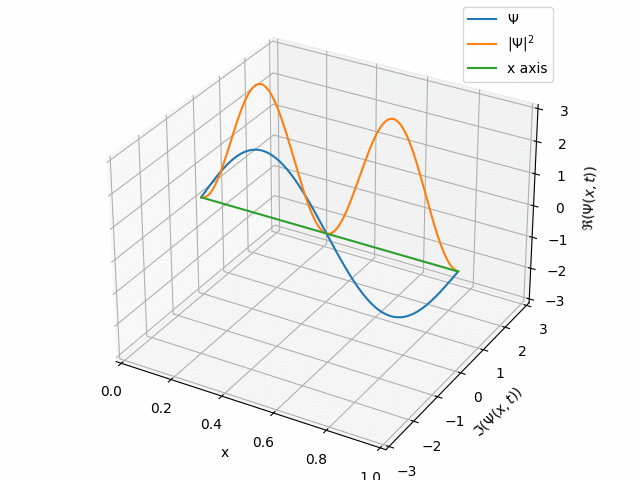

In [13]:
# Run this after setting save_as_gif=True above.
Image('./gifs/inf_square_well_3d_traces.gif', width=500)

In [ ]:
# Graph our custom real functions instead of the default.
ani = graph_wavefunction_animated([psi_sq, psi1_sq, psi2_sq], [0, L], [0, 2 * pi], [-1, 4],
                                  name='Infinite square well',
                                  legend=['$|\Psi|^2$', '$|\Psi_1|^2$', '$|\Psi_2|^2$'])

In [ ]:
# Graph 2D with a slider for time.
graph_wavefunction_slider(psi_func, x_range, t_range, y_range, name=name)